# `tf.data` API

* References
  * [`tf.data.Dataset` API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
  * [Importing data](https://www.tensorflow.org/guide/datasets) (Guideline Documents)
  * [Data Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets)

`tf.data` API has two (or three) new abstractions
* `tf.data.Dataset` represents a sequence of elements, in which each element contains one or more Tensor objects. For example, in an image pipeline, the image data and a label
  * Creating a source (e.g. Dataset.from_tensor_slices()) constructs a dataset from one or more `tf.Tensor` objects.
    * `tf.data.Dataset.from_tensors()`
    * `tf.data.Dataset.from_tensor_slices()`
    * `tf.data.TFRecordDataset`:  TFRecord format을 읽을 때
  * Applying a transformation (e.g. Dataset.batch()) constructs a dataset from one or more `tf.data.Dataset` objects.
* `tf.data.Iterator` provides the main way to extract elements from a dataset. The operation returned by `Iterator.get_next()` yields the next element of a `Dataset` when executed, and typically acts as the interface between input pipeline code and your model.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ssojux2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

### Loading MNIST dataset from `tf.keras.datasets`

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

### Show the MNIST

label = 3


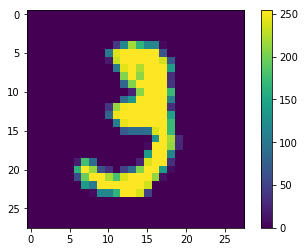

In [3]:
index = 10
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [4]:
# set N=50 for small dataset loading
N = 50
train_data = train_data[:N]
train_labels = train_labels[:N]
train_data = train_data / 255.
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data[:N]
test_labels = test_labels[:N]
test_data = test_data / 255.
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

## Input pipeline

1. You must define a source. `tf.data.Dataset`.
  * To construct a Dataset from some tensors in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
  * Other methods
    * `tf.data.TextLineDataset(filenames)`
    * `tf.data.FixedLengthRecordDataset(filenames)`
    * `tf.data.TFRecordDataset(filenames)`
2. Transformation
  * `Dataset.map()`: to apply a function to each element
  * `Dataset.batch()`
  * `Dataset.shuffle()`
3. `Iterator`
  * `Iterator.initializer`: which enables you to (re)initialize the iterator's state
  * `Iterator.get_next()`

### 1. Store data in `tf.data.Dataset`

* `tf.data.Dataset.from_tensor_slices((features, labels))`
* `tf.data.Dataset.from_generator(gen, output_types, output_shapes)`

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
print(train_dataset)
print(train_dataset.output_shapes)
print(train_dataset.output_types)

W0829 14:27:51.565242 139884319319872 deprecation.py:323] From <ipython-input-5-3434d91a59d6>:3: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0829 14:27:51.566016 139884319319872 deprecation.py:323] From <ipython-input-5-3434d91a59d6>:4: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


<DatasetV1Adapter shapes: ((28, 28), ()), types: (tf.float32, tf.int32)>
(TensorShape([Dimension(28), Dimension(28)]), TensorShape([]))
(tf.float32, tf.int32)


### 2. Transformaion

* `apply(transformation_func)`
* `batch(batch_size)`
* `concatenate(dataset)`
* `map(map_func)`
* `repeat(count=None)`
  * count=max_epochs
* `shuffle(buffer_size, seed=None, reshuffle_each_iteration=None)`

In [6]:
def cast_label(image, label):
  label = tf.cast(label, dtype=tf.float32)
  return image, label

In [31]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=2)
train_dataset = train_dataset.map(cast_label)
train_dataset = train_dataset.batch(batch_size = batch_size)

### 3. Iterator

* In eager execution, we can directly sample the batch dataset from `tf.data.Dataset` instead of using `Iterator`.
* We do not need to explicitly create an `tf.data.Iterator` object. 

In [32]:
for step, (x, y) in enumerate(train_dataset.take(10)):
  print("step: {}  label: {}".format(step, y))

step: 0  label: [5. 1. 0. 1. 4. 6. 2. 3. 9. 5. 1. 3. 9. 3. 4. 4.]
step: 1  label: [9. 4. 1. 6. 1. 8. 3. 6. 8. 8. 0. 7. 0. 3. 3. 9.]
step: 2  label: [9. 7. 0. 2. 9. 1. 5. 7. 6. 3. 9. 7. 2. 5. 1. 6.]
step: 3  label: [8. 2. 2. 3. 8. 9. 1. 5. 4. 8. 8. 9. 6. 1. 5. 6.]
step: 4  label: [6. 3. 3. 7. 0. 5. 8. 5. 4. 2. 3. 3. 4. 9. 9. 1.]
step: 5  label: [2. 0. 3. 1. 1. 3. 0. 9. 7. 1. 6. 0. 7. 9. 1. 9.]
step: 6  label: [4. 7. 6. 2.]


#### General method for importing data

In [22]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size, drop_remainder=True)

In [23]:
max_epochs = 2
for epoch in range(max_epochs):
  for step, (x, y) in enumerate(train_dataset):
    print("step: {}  label: {}".format(step, y))

step: 0  label: [2 1 6 6 3 4 3 5 5 6 9 0 9 0 7 9]
step: 1  label: [8 9 4 2 7 3 1 5 3 6 2 3 4 1 2 9]
step: 2  label: [4 7 0 1 8 5 7 8 1 6 9 3 9 1 0 1]
step: 0  label: [2 1 6 6 3 4 3 5 5 6 9 0 9 0 7 9]
step: 1  label: [8 9 4 2 7 3 1 5 3 6 2 3 4 1 2 9]
step: 2  label: [4 7 0 1 8 5 7 8 1 6 9 3 9 1 0 1]
